In [1]:
library(tidyverse)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
audit_trial_data <- read_csv("https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv")
audit_risk_data <- read_csv("https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/audit_risk.csv")

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



In [3]:
audit_trial_data
audit_risk_data

Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,2,0.04,2,0.28,5,2,0.00,2,2,0,2,0,2,2,0
55.57,18,0.20,2,0.00,2,0.20,5,2,0.00,2,2,0,2,0,2,2,0
55.57,15,0.00,2,0.00,2,0.00,5,2,0.32,2,2,0,2,0,2,2,0


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,0
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,0
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,0


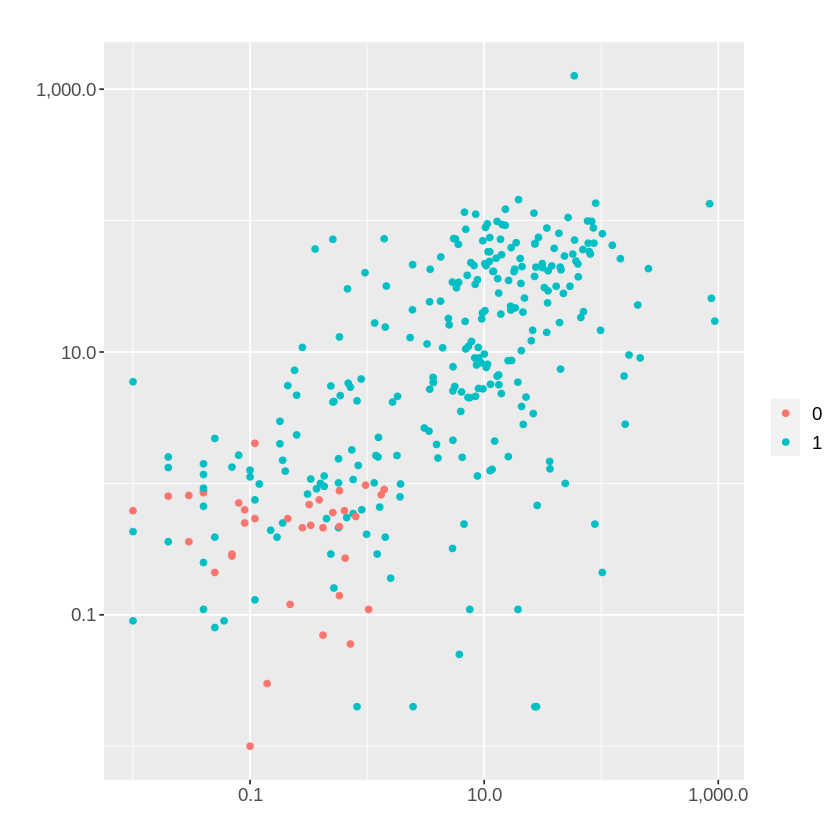

In [27]:
####EDGARS CODE
library(scales)
# Treat Risk as a categorical variable
audit_trial <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(PARA_A > 0, PARA_B > 0, Money_Value > 0) %>%
    ggplot(aes(x = Money_Value, y = PARA_B, colour = Risk)) +
    geom_point() +
    labs(x = "", y = "", colour = "") +
    ggtitle("") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma())

audit_trial

#As PARA_B value increases, so does the Money_Value. At that point all companies were audited